# "NMT by Jointly Learning to Align and Translate" Implementation

original paper: https://arxiv.org/abs/1409.0473

In [1]:
import torch
import numpy as np
from model.NMTutils import build_model, evaluation, BLEU, get_attention_figure

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.cuda.current_device()
# USE_CUDA = False
# DEVICE = -1

## Prepare Loader

modelcode:

    batch_size={'0': 1, '1': 64, '2': 128, '3': 256},
    embed_size={'1': 300, '2': 256},
    hidden_size={'1': 600, '2': 512},
    hidden_layer={'3': 3, '4': 4, '5': 5, '6': 6},
    drop_rate={'0': 0.0, '1': 0.5, '2': 0.1},
    method={'1': 'general', '2': 'paper'},
    layernorm={'0': False, '1': True}

In [3]:
lang1 = 'eng'
lang2 = 'fra'
modelcode_small = ['1113010', '1113110', '1113010', '1113110', '1113110', 
                  '1113110', '1113110', '1224210', '1225210', '1226210',
                  '1226220', '2224210', '2225210', '2224210']
modelcode_filtered = ['3224210', '3224210', '3224210']
modelcode_filtered2 = ['2224210']
modelcode_small_layernorm = ['2224211']

## architecture

![](./pics/encoder_decoder_att.png)

---

## Load model parameters & test

It's not proper way using "cross entropy loss" to measure translation is translated well. Better use BLEU score.

In [4]:
for i, code in enumerate(modelcode_small, 1):
    enc, dec, loss_function, test_loader, _ = build_model(i, code, lang1, lang2, file_path='./data/en_fa/', 
                                                          file_type='small', use_cuda=USE_CUDA, device=DEVICE)
    
    test_losses = evaluation(enc, dec, loss_function, loader=test_loader)
    print('model {} | test_losses: {}'.format(i, np.mean(test_losses)))

model 1 | test_losses: 3.373755919933319
model 2 | test_losses: 2.8649613857269287
model 3 | test_losses: 2.1464365780353547
model 4 | test_losses: 2.0280180394649507
model 5 | test_losses: 2.0105520367622374
model 6 | test_losses: 1.9621197938919068
model 7 | test_losses: 1.9139114558696746
model 8 | test_losses: 2.0558784663677216
model 9 | test_losses: 2.1233213245868683
model 10 | test_losses: 2.9488046526908875
model 11 | test_losses: 2.034368175268173
model 12 | test_losses: 2.0197078943252564
model 13 | test_losses: 2.2299065351486207
model 14 | test_losses: 2.2031670570373536


In [6]:
for i, code in enumerate(modelcode_filtered, 15):
    enc, dec, loss_function, test_loader, _ = build_model(i, code, lang1, lang2, file_path='./data/en_fa/', 
                                                          file_type='filtered', use_cuda=USE_CUDA, device=DEVICE)
    
    test_losses = evaluation(enc, dec, loss_function, loader=test_loader)
    print('model {} | test_losses: {}'.format(i, np.mean(test_losses)))

model 15 | test_losses: 2.202761650085449
model 16 | test_losses: 2.2258689284324644
model 17 | test_losses: 2.191823887825012


## Visualize Attention And Scroing

### BLEU

1. Prepare a data set, 1 source to many references sentences.
2. Count **N-Gram** in hypothesis(which is your output sentences): $Count(Ngram)$
3. For **N-Gram** words, count these words in references sentences: $Count_{clip}(Ngram)$
4. Combine:
$$p_n = \dfrac{\sum_{Ngram \in y} Count_{clip}(Ngram)}{\sum_{Ngram \in y} Count(Ngram)}$$
5. Calculate BLEU score:
$$BLEU = BP \times \exp(\dfrac{1}{N} \sum_{n=1}^N p_n)$$
which, $BP= \begin{cases}1\quad if\ len(hypothesis) > len(reference) \\ 
\exp(1-\frac{len(hypothesis)}{len(reference)}) \quad otherwise \end{cases}$ 


Why not use Precision?

$$Precision = \dfrac{TRUE\ detections}{whole\ detections\ of\ an\ algorithm}$$

**Precision** means how many apperance of a word that the model predicted are detected in the reference sentences. Like example below

Target:
* Ref1: The cat on the mat
* Ref2: There is a cat on the mat

Output:
* the the the the the the the 

If we use **Precision**, Output Precision = 7/7

Sometimes we modify **TRUE detections** to use the maximum counts of a word in a sentence. But it is not enough to score a sentence generatation.


### Conclusion

Performance was not good. You can findout sometimes generate well sometimes not.

I think models are not trained enough or not big(deep) enough to capture all sentences feature. In the paper(https://arxiv.org/abs/1409.0473), they used 

* hidden layer size = 1000
* word embedding dimension = 620
* attention hidden unit size = 1000

However, because of my GPU only has 6 GB memory, I can't make larger network. Maybe i'll try cpu to do this.

======== Model 1 ========
model: hidden 600 / embed 300 / num_hidden_layer 3 / attention_method general
Source :  i think i can do better .
Truth :  je pense pouvoir faire mieux .
Prediction :  je pense que je peux faire . .
BLEU Score:  0.7071
References:  ['je pense que je peux faire mieux .', 'je pense pouvoir faire mieux .']


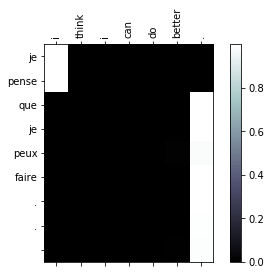

======== Model 2 ========
model: hidden 600 / embed 300 / num_hidden_layer 3 / attention_method general
Source :  i think i can do better .
Truth :  je pense pouvoir faire mieux .
Prediction :  je pense que je peux mieux .
BLEU Score:  0.7071
References:  ['je pense que je peux faire mieux .', 'je pense pouvoir faire mieux .']


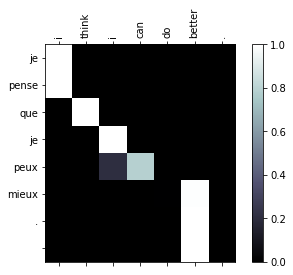

======== Model 3 ========
model: hidden 600 / embed 300 / num_hidden_layer 3 / attention_method general
Source :  i think i can do better .
Truth :  je pense pouvoir faire mieux .
Prediction :  je je je je peux peux faire mieux .
BLEU Score:  0.3549
References:  ['je pense que je peux faire mieux .', 'je pense pouvoir faire mieux .']


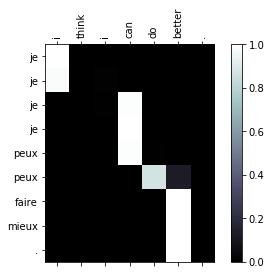

======== Model 4 ========
model: hidden 600 / embed 300 / num_hidden_layer 3 / attention_method general
Source :  i think i can do better .
Truth :  je pense pouvoir faire mieux .
Prediction :  je pense que je peux .
BLEU Score:  0.7953
References:  ['je pense que je peux faire mieux .', 'je pense pouvoir faire mieux .']


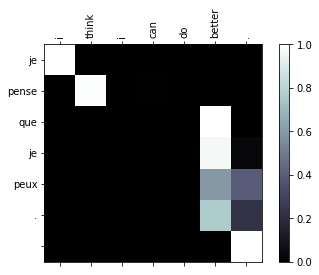

======== Model 5 ========
model: hidden 600 / embed 300 / num_hidden_layer 3 / attention_method general
Source :  i think i can do better .
Truth :  je pense pouvoir faire mieux .
Prediction :  je pense que je je mieux mieux .
BLEU Score:  0.4111
References:  ['je pense que je peux faire mieux .', 'je pense pouvoir faire mieux .']


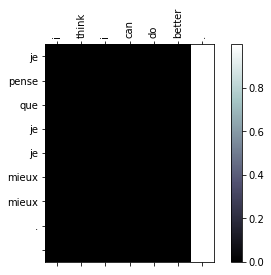

======== Model 6 ========
model: hidden 600 / embed 300 / num_hidden_layer 3 / attention_method general
Source :  i think i can do better .
Truth :  je pense pouvoir faire mieux .
Prediction :  je pense je faire peux mieux .
BLEU Score:  0.0
References:  ['je pense que je peux faire mieux .', 'je pense pouvoir faire mieux .']


/usr/local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


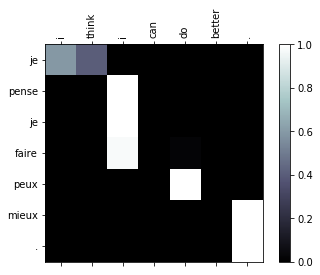

======== Model 7 ========
model: hidden 600 / embed 300 / num_hidden_layer 3 / attention_method general
Source :  i think i can do better .
Truth :  je pense pouvoir faire mieux .
Prediction :  je pense que je peux mieux mieux .
BLEU Score:  0.5946
References:  ['je pense que je peux faire mieux .', 'je pense pouvoir faire mieux .']


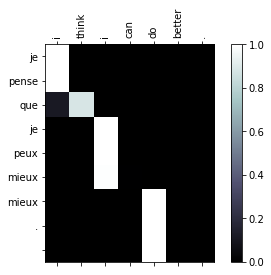

======== Model 8 ========
model: hidden 512 / embed 256 / num_hidden_layer 4 / attention_method general
Source :  i think i can do better .
Truth :  je pense pouvoir faire mieux .
Prediction :  je que je peux peux mieux .
BLEU Score:  0.0
References:  ['je pense que je peux faire mieux .', 'je pense pouvoir faire mieux .']


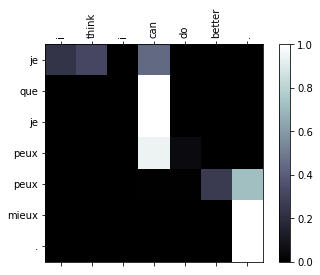

======== Model 9 ========
model: hidden 512 / embed 256 / num_hidden_layer 5 / attention_method general
Source :  i think i can do better .
Truth :  je pense pouvoir faire mieux .
Prediction :  je pense que je peux .
BLEU Score:  0.7953
References:  ['je pense que je peux faire mieux .', 'je pense pouvoir faire mieux .']


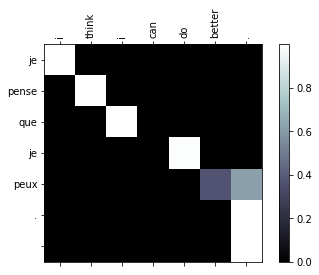

======== Model 10 ========
model: hidden 512 / embed 256 / num_hidden_layer 6 / attention_method general
Source :  i think i can do better .
Truth :  je pense pouvoir faire mieux .
Prediction :  je peux que j me . .
BLEU Score:  0.0
References:  ['je pense que je peux faire mieux .', 'je pense pouvoir faire mieux .']


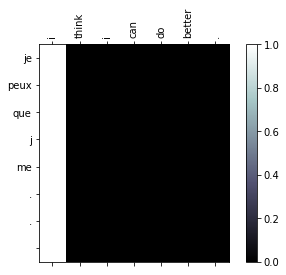

======== Model 11 ========
model: hidden 512 / embed 256 / num_hidden_layer 6 / attention_method paper
Source :  i think i can do better .
Truth :  je pense pouvoir faire mieux .
Prediction :  je pense que je peux mieux mieux .
BLEU Score:  0.5946
References:  ['je pense que je peux faire mieux .', 'je pense pouvoir faire mieux .']


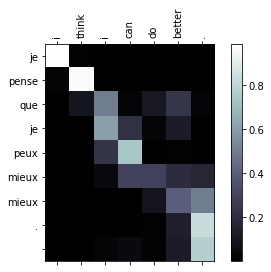

======== Model 12 ========
model: hidden 512 / embed 256 / num_hidden_layer 4 / attention_method general
Source :  i think i can do better .
Truth :  je pense pouvoir faire mieux .
Prediction :  je pense que je peux faire faire .
BLEU Score:  0.7071
References:  ['je pense que je peux faire mieux .', 'je pense pouvoir faire mieux .']


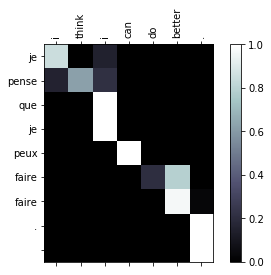

======== Model 13 ========
model: hidden 512 / embed 256 / num_hidden_layer 5 / attention_method general
Source :  i think i can do better .
Truth :  je pense pouvoir faire mieux .
Prediction :  je pense que je peux faire faire .
BLEU Score:  0.7071
References:  ['je pense que je peux faire mieux .', 'je pense pouvoir faire mieux .']


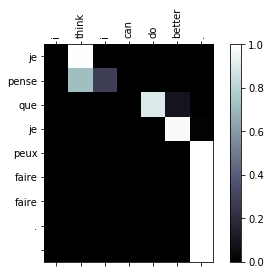

======== Model 14 ========
model: hidden 512 / embed 256 / num_hidden_layer 4 / attention_method general
Source :  i think i can do better .
Truth :  je pense pouvoir faire mieux .
Prediction :  je pense que je peux mieux mieux mieux .
BLEU Score:  0.5133
References:  ['je pense que je peux faire mieux .', 'je pense pouvoir faire mieux .']


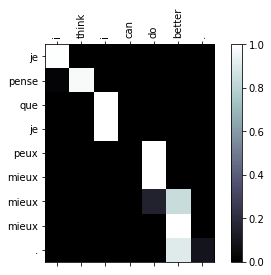

In [5]:
file_type = 'small'
model_type = modelcode_small

get_attention_figure(file_type, model_type, lang1='eng', lang2='fra', use_cuda=USE_CUDA, device=DEVICE, 
                     start_model_idx=1)

======== Model 15 ========
model: hidden 512 / embed 256 / num_hidden_layer 4 / attention_method general
Source :  you re not one of them , are you ?
Truth :  vous n etes pas des leurs , si ?
Prediction :  n n etes pas des une , si si ?
BLEU Score:  0.3433
References:  ['tu n es pas des leurs , si ?', 'vous n etes pas des leurs , si ?']


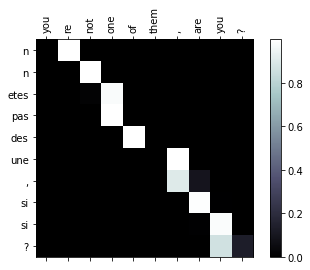

======== Model 16 ========
model: hidden 512 / embed 256 / num_hidden_layer 4 / attention_method general
Source :  you re not one of them , are you ?
Truth :  vous n etes pas des leurs , si ?
Prediction :  vous n n es pas partie partie ,
BLEU Score:  0.0
References:  ['tu n es pas des leurs , si ?', 'vous n etes pas des leurs , si ?']


/usr/local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


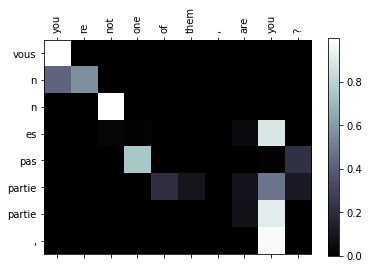

======== Model 17 ========
model: hidden 512 / embed 256 / num_hidden_layer 4 / attention_method general
Source :  you re not one of them , are you ?
Truth :  vous n etes pas des leurs , si ?
Prediction :  vous n etes etes pas un eux , si ?
BLEU Score:  0.0
References:  ['tu n es pas des leurs , si ?', 'vous n etes pas des leurs , si ?']


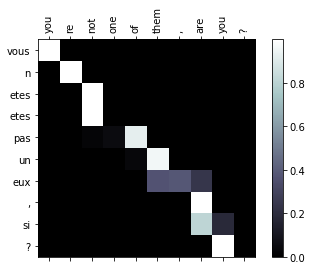

In [12]:
file_type = 'filtered'
model_type = modelcode_filtered
get_attention_figure(file_type, model_type, lang1='eng', lang2='fra', use_cuda=USE_CUDA, device=DEVICE, 
                     start_model_idx=15)

======== Model 18 ========
model: hidden 512 / embed 256 / num_hidden_layer 4 / attention_method general
Source :  do you want to know what i think ?
Truth :  vous voulez savoir ce que j ' en pense ?
Prediction :  voulez voulez savoir savoir ce que je pense ?
BLEU Score:  0.6389
References:  ['veux - tu savoir ce que je pense ?', 'voulez - vous savoir ce que je pense ?', "tu veux savoir ce que j ' en pense ?", "vous voulez savoir ce que j ' en pense ?"]


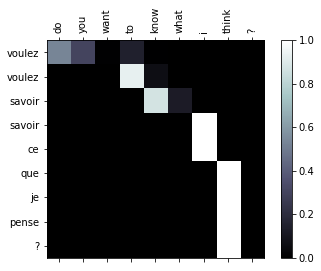

In [13]:
file_type = 'filtered2'
model_type = modelcode_filtered2
get_attention_figure(file_type, model_type, lang1='eng', lang2='fra', use_cuda=USE_CUDA, device=DEVICE, 
                     start_model_idx=18)